In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import warnings
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
%matplotlib inline
warnings.filterwarnings("ignore")

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'public'
password = "jinaf3279"

con = psycopg2.connect(dbname=dbname, user=sqluser, password = password)
cur = con.cursor()

cur.execute('SET search_path to {}'.format(schema_name))

In [3]:
###############################################################################################################
######################                return subject_id who get CKD                        ####################
###############################################################################################################
def getSubID():
    query = """
    select subject_id from diagnoses_icd where icd9_code in ('5851','5852','5853','5854','5855','5859')
    """
    df = pd.read_sql_query(query,con)
    cur.execute("select subject_id from diagnoses_icd where icd9_code in ('5851','5852','5853','5854','5855','5859')")
    rows = cur.fetchall()
    subID=[]
    for r in rows:
        subID.append(r[0])
    return subID

#get CKD patients info
t = tuple(getSubID())


In [4]:
#df1 from patients

query = """
select subject_id, gender, dod from patients where subject_id in {}
""".format(t)
df1 = pd.read_sql_query(query,con)
df1.fillna(0, inplace=True)
df1

,subject_id,gender,dod
0,68,F,2174-02-11 00:00:00
1,85,M,2167-09-12 00:00:00
2,109,F,2142-08-30 00:00:00
3,124,M,2166-02-01 00:00:00
4,145,F,0
...,...,...,...
3779,99901,M,0
3780,99923,M,0
3781,99936,F,2186-11-28 00:00:00
3782,99938,M,0


In [5]:
query = """
        select distinct subject_id, ethnicity, deathtime from admissions where subject_id in {}
        """.format(t)
df2 = pd.read_sql_query(query,con)
for j in range(len(df2)):
    if df2['ethnicity'][j][0:5] == 'ASIAN':
        df2['ethnicity'][j] = 'ASIAN'
    elif df2['ethnicity'][j][0:5] == 'WHITE':
        df2['ethnicity'][j] = 'WHITE'
    elif df2['ethnicity'][j][0:8] == 'HISPANIC':
        df2['ethnicity'][j] = 'HISPANIC'
    elif df2['ethnicity'][j][0:13] == 'BLACK/AFRICAN':
        df2['ethnicity'][j] = 'BLACK'
    elif df2['ethnicity'][j][0:15] == 'AMERICAN INDIAN' or df2['ethnicity'][j][0:6] == 'INDIAN' :
        df2['ethnicity'][j] = 'ASIAN'
    elif df2['ethnicity'][j][0:7] == 'UNKNOWN' or df2['ethnicity'][j][0:6] == 'UNABLE' or df2['ethnicity'][j][0:7] == 'PATIENT':
        df2['ethnicity'][j] = None
    else:
        df2['ethnicity'][j] = 'OTHER'
for j in range(len(df2)):
    if pd.isnull(df2['deathtime'])[j]:
        df2['deathtime'][j] = 0
        
#drop the none value in ethnicity
df2 = df2.dropna()
df2

,subject_id,ethnicity,deathtime
0,68,BLACK,0
1,85,WHITE,0
2,109,BLACK,2142-08-30 15:20:00
3,109,BLACK,0
4,124,WHITE,2166-02-01 06:55:00
...,...,...,...
4194,99901,WHITE,0
4195,99923,WHITE,0
4196,99936,WHITE,0
4197,99938,WHITE,0


In [6]:
df = pd.merge(df1,df2, how='inner', on='subject_id')
df=df.dropna()

df

,subject_id,gender,dod,ethnicity,deathtime
0,68,F,2174-02-11 00:00:00,BLACK,0
1,85,M,2167-09-12 00:00:00,WHITE,0
2,109,F,2142-08-30 00:00:00,BLACK,2142-08-30 15:20:00
3,109,F,2142-08-30 00:00:00,BLACK,0
4,124,M,2166-02-01 00:00:00,WHITE,2166-02-01 06:55:00
...,...,...,...,...,...
3986,99901,M,0,WHITE,0
3987,99923,M,0,WHITE,0
3988,99936,F,2186-11-28 00:00:00,WHITE,0
3989,99938,M,0,WHITE,0


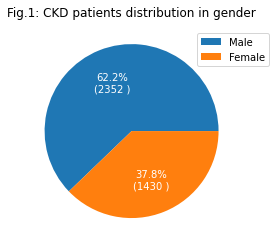

<class 'list'>


In [7]:
###############################################################################################################
######################                CKD distribution by GENDER                           ####################
###############################################################################################################
cur.execute("select subject_id, gender, dob, dod from patients where subject_id in {}".format(t))
rows = cur.fetchall()
gender = []
for r in rows:
    gender.append(r[1])

    
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

gender = [gender.count('M'),gender.count('F')]
label = ['Male', 'Female']
plt.pie(gender, labels=label, autopct=lambda pct: func(pct, gender),
       textprops=dict(color="w"))
plt.legend(label,loc=(.8,.8))
plt.title('Fig.1: CKD patients distribution in gender')
plt.show()
print(type(rows))

    


In [8]:

cur.execute("select subject_id, gender, dob, dod from patients where subject_id in {}".format(t))
rows = cur.fetchall()
gender = []
for r in rows:
    gender.append(r[1])

gender = [gender.count('M'),gender.count('F')]
label = ['Male', 'Female']

male_l, fm_l, male_d, fm_d  = 0, 0, 0, 0

for r in rows:
    
    if r[3]==None:
        if r[1]=="M":
            male_l +=1
        elif r[1]=="F":
            fm_l+=1
    else:
        if r[1]=="M":
            male_d +=1
        elif r[1]=="F":
            fm_d+=1
    

male_l, fm_l, male_d, fm_d

(1125, 652, 1228, 779)

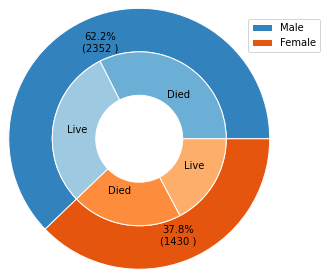

In [9]:
fig, ax = plt.subplots()

g = ['Died', 'Live', 'Died', 'Live']
vals = np.array([[male_d, male_l],[fm_d, fm_l]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.array([0,1,2,3])*4)
inner_colors = cmap([1,2,5,6])

ax.pie(vals.sum(axis=1), radius=1.5, colors=outer_colors,autopct=lambda pct: func(pct, gender),pctdistance = 0.8,
       wedgeprops=dict(width=.5, edgecolor='w'))

ax.pie(vals.flatten(), radius=1, colors=inner_colors,
       wedgeprops=dict(width=.5, edgecolor='w'),labels=g, labeldistance=0.6)

plt.legend(label, loc = (1,.9))
plt.show()

Text(0.5, 1.0, 'Fig.3: CKD Mortality Rate by Gender')

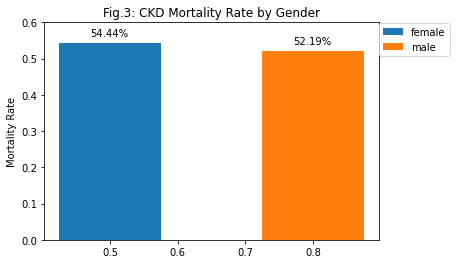

In [10]:
plt.bar(0.5, fm_d/gender[1] ,.15)
plt.bar(0.8, male_d/gender[0],.15)
plt.text(0.47,0.562,str(round(fm_d/gender[1]*100,2))+'%')
plt.text(0.77,0.54,str(round(male_d/gender[0]*100,2))+'%')
plt.ylim(0,0.6)
plt.ylabel('Mortality Rate')
plt.legend(['female','male'], loc=(1,0.845))
plt.title('Fig.3: CKD Mortality Rate by Gender')

In [11]:
###############################################################################################################
######################                CKD distribution by RACE                             ####################
###############################################################################################################
race = df['ethnicity'].unique()


ethnicity = []
for i in range(len(df['deathtime'])):
    if df['deathtime'][i]  != 0 or df['dod'][i]!=0:
        ethnicity.append(df['ethnicity'][i])
death = {}
for i in range(len(race)):
    death[race[i]]=ethnicity.count(race[i])

ori = [492, 3141, 105, 126, 127]

die = []
for i in death.values():
    die.append(i)
live = []
for i in range(len(ori)):
    live.append(ori[i]-die[i])
live

[248, 1269, 57, 72, 76]

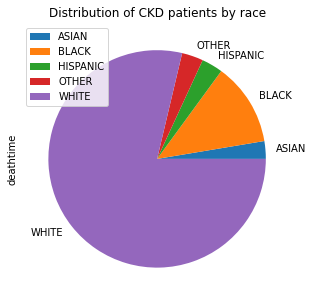

In [12]:
n = df.set_index(["ethnicity", 'subject_id']).count(level="ethnicity")
n.plot.pie(y='deathtime',figsize=(5, 5), title='Distribution of CKD patients by race')
plt.show()

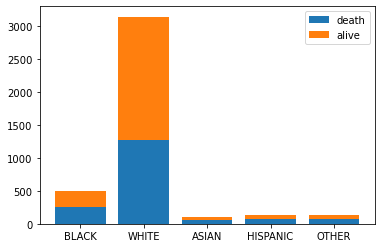

In [13]:
plt.bar(death.keys(), live)
plt.bar(death.keys(), death.values(), bottom=live)

plt.legend(['death', 'alive'])
plt.show()


Text(0.5, 1.0, 'Mortality rate by race')

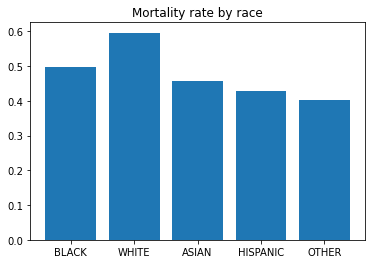

In [14]:
mo_race = []

value = list(death.values())
for i in range(len(ori)):
    mo_race.append(value[i]/ori[i])
plt.bar(death.keys(), mo_race)
plt.title('Mortality rate by race')

In [15]:
df

,subject_id,gender,dod,ethnicity,deathtime
0,68,F,2174-02-11 00:00:00,BLACK,0
1,85,M,2167-09-12 00:00:00,WHITE,0
2,109,F,2142-08-30 00:00:00,BLACK,2142-08-30 15:20:00
3,109,F,2142-08-30 00:00:00,BLACK,0
4,124,M,2166-02-01 00:00:00,WHITE,2166-02-01 06:55:00
...,...,...,...,...,...
3986,99901,M,0,WHITE,0
3987,99923,M,0,WHITE,0
3988,99936,F,2186-11-28 00:00:00,WHITE,0
3989,99938,M,0,WHITE,0


In [16]:
pd.get_dummies(df.gender)

,F,M
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
3986,0,1
3987,0,1
3988,1,0
3989,0,1


In [17]:
# df = df.drop(['dod','deathtime'],1)

'''
F is 0, M is 1 
'''

for i in range(len(df)):
    if df['gender'][i]== 'F':
        df['gender'][i] = 0
    elif df['gender'][i]== 'M':
        df['gender'][i] = 1

        
'''
Other is 0, Asian is 1, Black is 2, Hispanic is 3, White is 4
'''
for i in range(len(df)):
    if df['ethnicity'][i]=='OTHER':
        df['ethnicity'][i]=0
    elif df['ethnicity'][i]=='ASIAN':
        df['ethnicity'][i]=1
    elif df['ethnicity'][i]=='BLACK':
        df['ethnicity'][i]=2
    elif df['ethnicity'][i]=='HISPANIC':
        df['ethnicity'][i]=3
    elif df['ethnicity'][i]=='WHITE':
        df['ethnicity'][i]=4 

'''
died is 0, alive is 1
'''       
for i in range(len(df)):
    if df['deathtime'][i]!=0 or df['dod'][i]!=0:
        df['deathtime'][i] = 0
    else:
        df['deathtime'][i] = 1
df = df.drop(['dod'],1)

In [18]:
# pd.set_option('display.max_rows', df.shape[0]+1)
df

,subject_id,gender,ethnicity,deathtime
0,68,0,2,0
1,85,1,4,0
2,109,0,2,0
3,109,0,2,0
4,124,1,4,0
...,...,...,...,...
3986,99901,1,4,1
3987,99923,1,4,1
3988,99936,0,4,0
3989,99938,1,4,1


In [19]:

X = df[['gender', 'ethnicity']]
y=df['deathtime'].astype('int')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])


<IPython.core.display.Javascript object>

In [20]:

print('Accuracy: ',sklearn.metrics.accuracy_score(y_test, y_pred))


<IPython.core.display.Javascript object>

Accuracy:  0.5742904841402338


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.84      0.69       683
           1       0.51      0.22      0.31       515

    accuracy                           0.57      1198
   macro avg       0.55      0.53      0.50      1198
weighted avg       0.56      0.57      0.53      1198

